# Data Set Information:

In [Cortez and Morais, 2007], the output 'area' was first transformed with a ln(x+1) function.
Then, several Data Mining methods were applied. After fitting the models, the outputs were
post-processed with the inverse of the ln(x+1) transform. Four different input setups were
used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
(REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
the SVM model predicts better small fires, which are the majority.



# Attribute Information:

For more information, read [Cortez and Morais, 2007].
1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

# Citatation -

[Cortez and Morais, 2007] P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. Available at: [Web Link]

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
from sklearn import svm


import os

import sys
import sklearn

In [3]:
df = pd.read_csv('C:/Users/divya/Downloads/forestfires (1).csv')

In [4]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [5]:
df['fire_scale'] = df['area'].apply(lambda x: 'no_fire' if (x==0) else
                                                      'small_fire' if ((x>0)&(x<2))else
                                                      'large_fire'
                                           )
print(df.shape)
df.head()

(517, 14)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire_scale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,no_fire
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,no_fire
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,no_fire
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,no_fire
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,no_fire


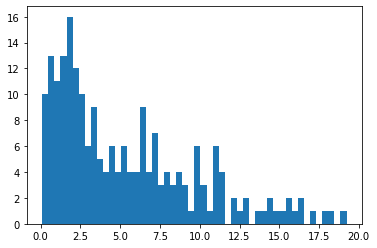

In [6]:
plt.hist(df[(df['area']>0)&(df['area']<20)].area, bins=50)

plt.show()

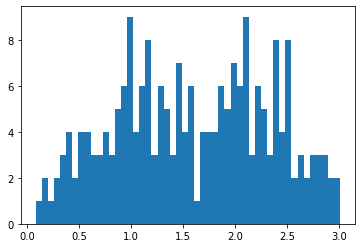

In [7]:
plt.hist(np.log(df[(df['area']>0)&(df['area']<20)].area + 1), bins=50)

plt.show()


<BarContainer object of 12 artists>

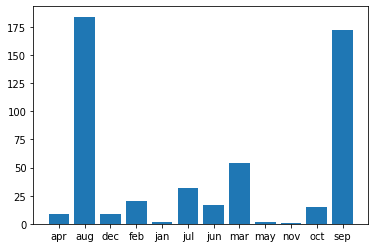

In [8]:
t = df.groupby(['month'])['month'].count()
plt.bar(t.index, t)

In [9]:
## We can clearly see the bias towards two months aug and sep

In [10]:
df.groupby(['month', 'fire_scale'])['fire_scale'].count()

month  fire_scale
apr    large_fire     4
       no_fire        5
aug    large_fire    71
       no_fire       85
       small_fire    28
dec    large_fire     9
feb    large_fire     9
       no_fire       10
       small_fire     1
jan    no_fire        2
jul    large_fire    12
       no_fire       14
       small_fire     6
jun    large_fire     5
       no_fire        9
       small_fire     3
mar    large_fire    16
       no_fire       35
       small_fire     3
may    large_fire     1
       no_fire        1
nov    no_fire        1
oct    large_fire     5
       no_fire       10
sep    large_fire    76
       no_fire       75
       small_fire    21
Name: fire_scale, dtype: int64

<BarContainer object of 7 artists>

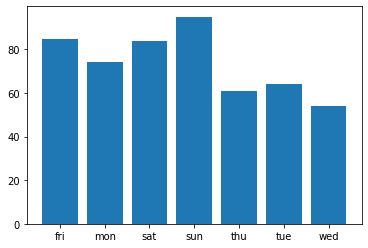

In [11]:
t = df.groupby(['day'])['day'].count()
plt.bar(t.index, t)

In [12]:
## days look fine 

## PART I


In [13]:
#d = df,copy()
d = df[df['area']>0].copy()

In [14]:
print(d.shape)
# We have sampled the data in months that are not equal to 
for m in d['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = d[d['month']==m].sample(350, replace=True)
        d = pd.concat([d, temp], axis=0)

print(d.shape)

(270, 14)
(3070, 14)


<BarContainer object of 10 artists>

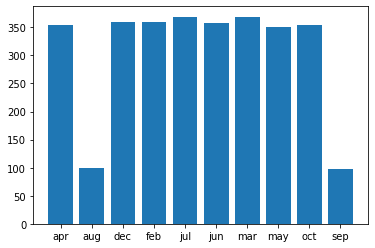

In [15]:
# plot
t = d.groupby(['month'])['month'].count()
plt.bar(t.index, t)

In [16]:
## Regression

In [17]:
#Converting to one's and zero's
X = d.drop(['area', 'fire_scale'], axis=1)
y = d['area']
X = pd.get_dummies(X, ['month', 'day'])
X.head(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
138,9,9,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,...,0,0,0,0,0,0,0,0,1,0
139,1,4,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,...,0,0,1,0,0,0,0,0,1,0


In [18]:
scaling_col= ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

In [19]:
# Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y+1), shuffle=True)
print(x_train.shape, x_test.shape)

(2302, 27) (768, 27)


In [21]:
#Spliting to scale

In [22]:
x_training_original = x_train.loc[:, scaling_col]
x_training_categorical = x_train.drop(scaling_col, axis=1)

x_testing_original = x_test.loc[:, x_training_original.columns]
x_testing_categorical = x_test.loc[:, x_training_categorical.columns]

In [23]:
# Standard scalar

In [24]:
scl=preprocessing.StandardScaler()
scl.fit(x_training_original)

x_training_original = scl.transform(x_training_original)
x_testing_original = scl.transform(x_testing_original)

# Combine
x_train = np.concatenate([x_training_original, np.array(x_training_categorical)], axis=1)
x_test = np.concatenate([x_testing_original, np.array(x_testing_categorical)], axis=1)

print(x_train.shape, x_test.shape)

(2302, 27) (768, 27)


## Model: LinearRegression

mse:  0.6864
mae:  0.6059
r2:  0.4136


Text(0, 0.5, 'y_pred')

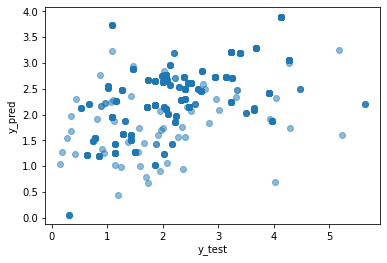

In [25]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

## SVM

mse:  0.3169
mae:  0.2789
r2:  0.7292


Text(0, 0.5, 'y_pred')

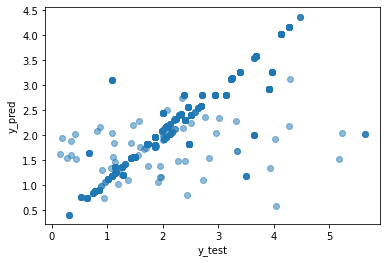

In [26]:
reg = svm.SVR(C=1, kernel='rbf', gamma='auto', max_iter=5e4, cache_size=1000)
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

# PART 2 

## Classification

In [27]:
df_classification = df.copy()

In [28]:
df_classification.fire_scale.value_counts()

no_fire       247
large_fire    208
small_fire     62
Name: fire_scale, dtype: int64

In [29]:
print(df_classification.shape)
for m in df_classification['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = df_classification[df_classification['month']==m].sample(300, replace=True)
        df_classification = pd.concat([df_classification, temp], axis=0)

print(df_classification.shape)

(517, 14)
(3517, 14)


In [30]:
# Convert to one's and zero's

In [31]:
Xc = df_classification.drop(['area', 'fire_scale'], axis=1)
yc = df_classification['fire_scale']

In [32]:
Xc = pd.get_dummies(Xc, ['month', 'day'])
Xc.head(2)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,1,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,1,0,0,0,0,0,0,1,0


In [33]:
scaling_col= ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

In [34]:
print(Xc.shape)
Xc = Xc[Xc.columns[(Xc.var(axis=0)>0).values]]
print(Xc.shape)

(3517, 29)
(3517, 29)


In [35]:
# Collinearity
print(Xc.shape)
x_corr = Xc.corr()**2

x_upper = x_corr.where(np.triu(np.ones(x_corr.shape), k=1).astype(np.bool))

# r2>0.7
drop_col = [col for col in x_upper.columns if any(x_upper[col] > 0.70)]

Xc = Xc.drop(drop_col, axis=1)
print(Xc.shape)

(3517, 29)
(3517, 29)


In [36]:
# Split

In [37]:
x_train, x_test, y_train, y_test = train_test_split(Xc, yc, 
                                                    shuffle=True, stratify=yc)
print(x_train.shape, x_test.shape)


(2637, 29) (880, 29)


In [38]:
# Split for scaling

In [39]:
x_training_original = x_train.loc[:, scaling_col]
x_training_categorical = x_train.drop(scaling_col, axis=1)

x_testing_original = x_test.loc[:, x_training_original.columns]
x_testing_categorical = x_test.loc[:, x_training_categorical.columns]

In [40]:
# Standard scalar

In [41]:
scl=preprocessing.StandardScaler()
scl.fit(x_training_original)

x_training_original = scl.transform(x_training_original)
x_testing_original = scl.transform(x_testing_original)

# Combine
x_train = np.concatenate([x_training_original, np.array(x_training_categorical)], axis=1)
x_test = np.concatenate([x_testing_original, np.array(x_testing_categorical)], axis=1)

print(x_train.shape, x_test.shape)

(2637, 29) (880, 29)


## Model: LogisticRegression

In [50]:
clf = linear_model.LogisticRegression(max_iter=1e7, penalty='elasticnet', solver='saga', l1_ratio=0.75)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acu = metrics.accuracy_score(y_test, y_pred)
print("acu: ", np.round(acu, 4))

cm = metrics.confusion_matrix(y_test, y_pred)
cm

acu:  0.7614


array([[206, 110,   3],
       [ 47, 464,   1],
       [ 14,  35,   0]], dtype=int64)

## Model: SVC

In [56]:
clf = svm.SVC(C=1, kernel='linear', gamma='auto', max_iter=5e4, cache_size=1000)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

acu = metrics.accuracy_score(y_test, y_pred)
print("acu: ", np.round(acu, 4))

cm = metrics.confusion_matrix(y_test, y_pred)
cm

acu:  0.7784


C:\Users\divya\Anaconda3\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


array([[222,  97,   0],
       [ 49, 463,   0],
       [ 13,  36,   0]], dtype=int64)

Feature: 0, Score: 0.57104
Feature: 1, Score: -0.40531
Feature: 2, Score: 0.59808
Feature: 3, Score: 0.47257
Feature: 4, Score: -1.00197
Feature: 5, Score: -0.13233
Feature: 6, Score: -0.07203
Feature: 7, Score: -0.11833
Feature: 8, Score: 0.43454
Feature: 9, Score: 0.01823
Feature: 10, Score: -1.21717
Feature: 11, Score: 0.56701
Feature: 12, Score: 2.18240
Feature: 13, Score: -0.85773
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.54242
Feature: 16, Score: -0.93156
Feature: 17, Score: -1.61225
Feature: 18, Score: 0.14297
Feature: 19, Score: -1.57547
Feature: 20, Score: 1.17868
Feature: 21, Score: 1.58069
Feature: 22, Score: 0.27997
Feature: 23, Score: 0.52404
Feature: 24, Score: -1.36003
Feature: 25, Score: -0.14516
Feature: 26, Score: 1.59232
Feature: 27, Score: -0.20257
Feature: 28, Score: -0.68857


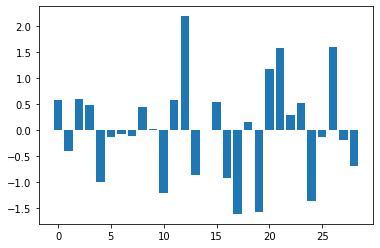

In [59]:
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


### Using the feature importance, we identified the important attributes that would be the driving factor in wildfire.

In [61]:
df_classification

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,fire_scale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,no_fire
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,no_fire
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,no_fire
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,no_fire
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,no_fire
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.0,no_fire
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.0,no_fire
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.0,no_fire
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.0,no_fire
